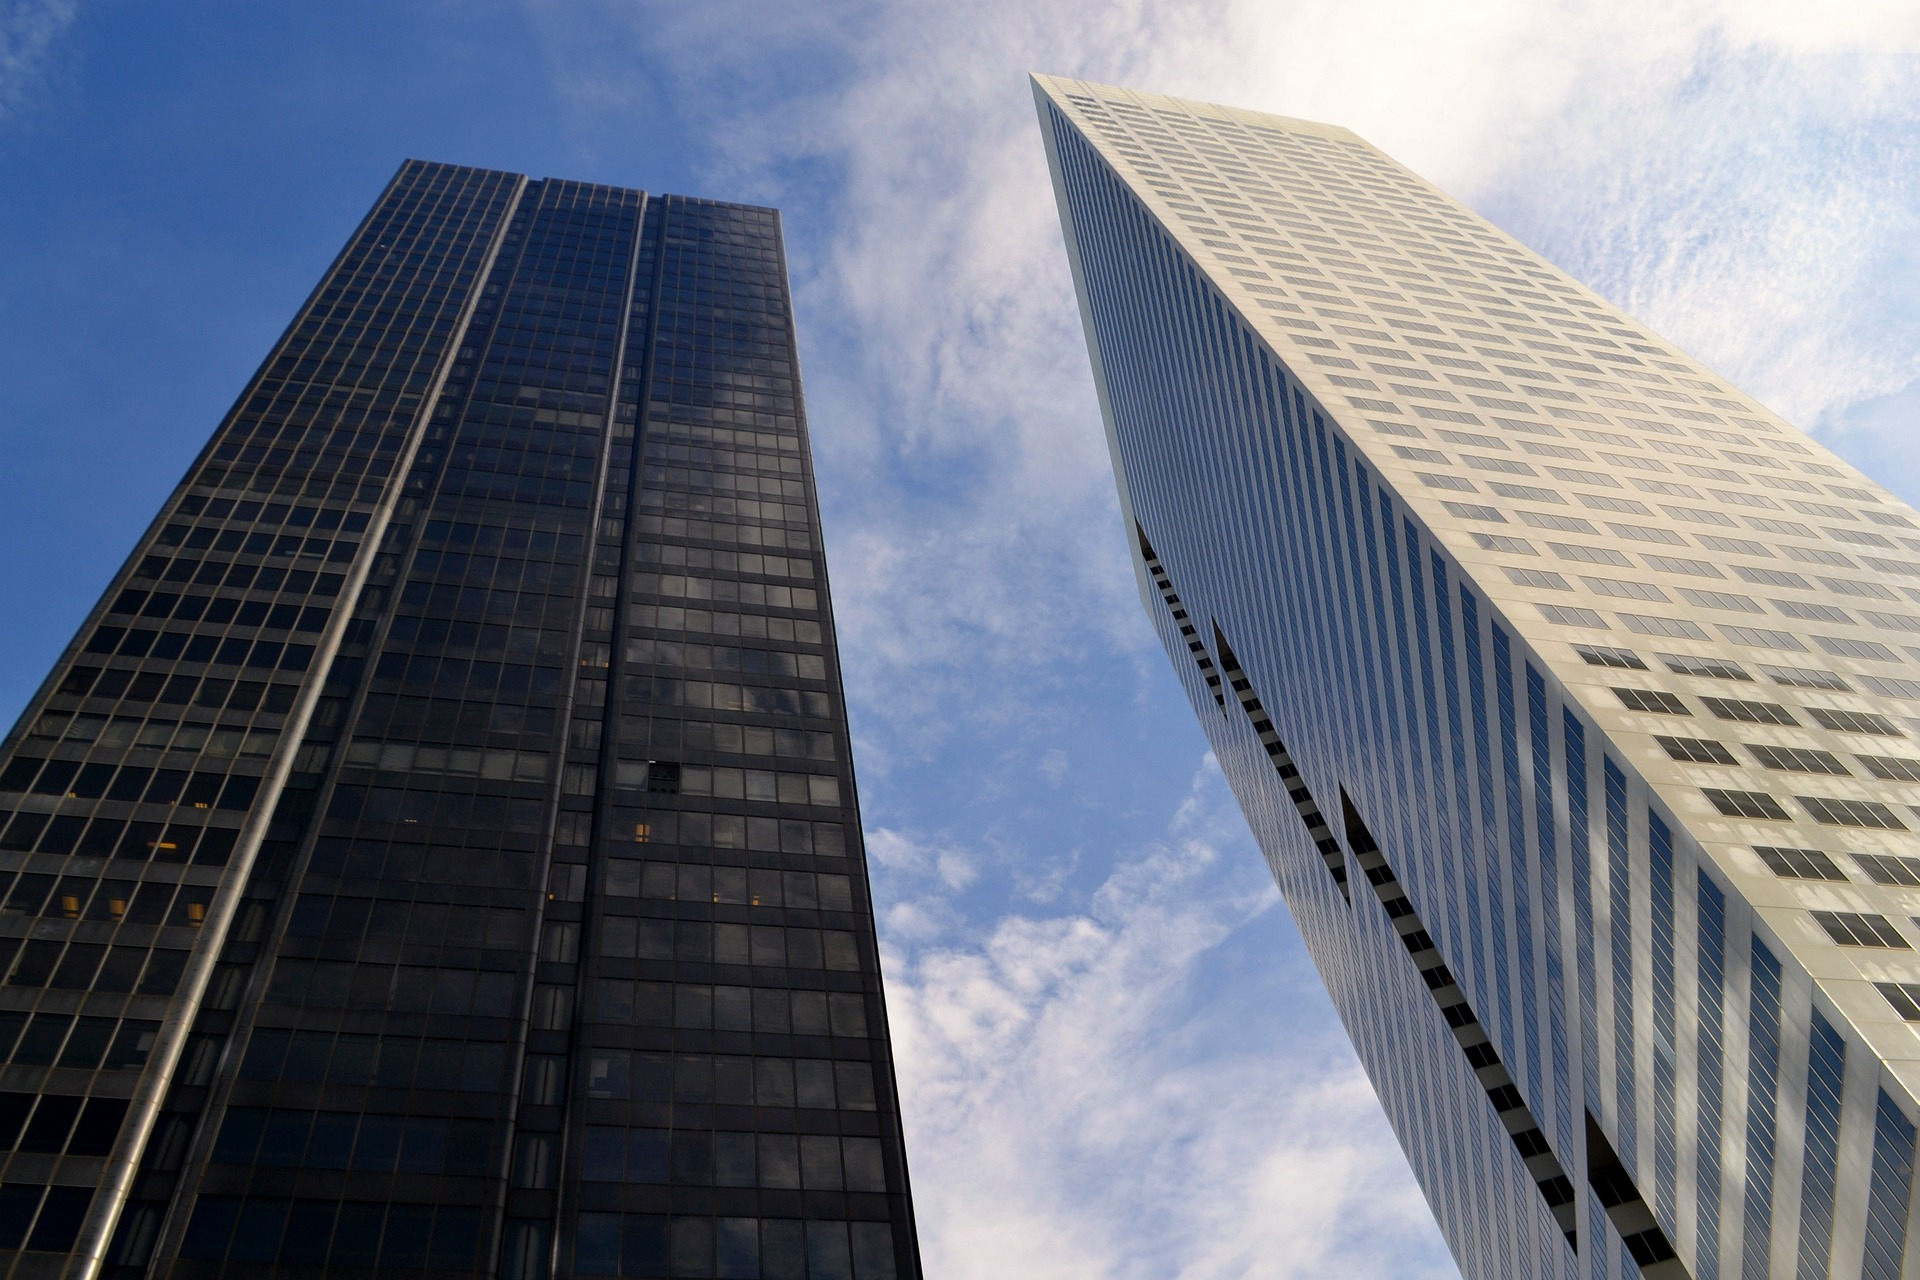

#S&P 500 Volume Time Series Analysis

The S&P data can be obtained from the yahoo finance weibsite (https://finance.yahoo.com/quote/%5EGSPC/history?period1=654220800&period2=1664064000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) through an API. An API, allows us to automatically collect this data without manually downloading and storing the data on the local PC. This is a gentle introduction into the usage of Hyper Tuned ARIMA models in modelling the S&P 500 Volume.

In [ ]:
pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 31.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Import the plotting library
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline


# Get the data for the stock GSPC
data = yf.download('^GSPC','2012-09-01','2022-10-08')
data.head()



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-04 00:00:00-04:00,1406.540039,1409.310059,1396.560059,1404.939941,1404.939941,3200310000
2012-09-05 00:00:00-04:00,1404.939941,1408.810059,1401.250000,1403.439941,1403.439941,3389110000
2012-09-06 00:00:00-04:00,1403.739990,1432.119995,1403.739990,1432.119995,1432.119995,3952870000
2012-09-07 00:00:00-04:00,1432.119995,1437.920044,1431.449951,1437.920044,1437.920044,3717620000
2012-09-10 00:00:00-04:00,1437.920044,1438.739990,1428.979980,1429.079956,1429.079956,3223670000


In [ ]:
# latest data
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-03 00:00:00-04:00,3609.780029,3698.350098,3604.929932,3678.429932,3678.429932,4806680000
2022-10-04 00:00:00-04:00,3726.459961,3791.919922,3726.459961,3790.929932,3790.929932,5146580000
2022-10-05 00:00:00-04:00,3753.250000,3806.909912,3722.659912,3783.280029,3783.280029,4293180000
2022-10-06 00:00:00-04:00,3771.969971,3797.929932,3739.219971,3744.520020,3744.520020,4252100000
2022-10-07 00:00:00-04:00,3706.739990,3706.739990,3620.729980,3639.659912,3639.659912,4449660000


In [ ]:
import pandas as pd
data.index = pd.DatetimeIndex(data.index)

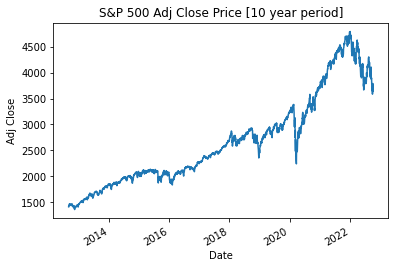

In [ ]:
# Plot the Adj Close of the GSPC
data['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('S&P 500 Adj Close Price [10 year period]')
plt.show()


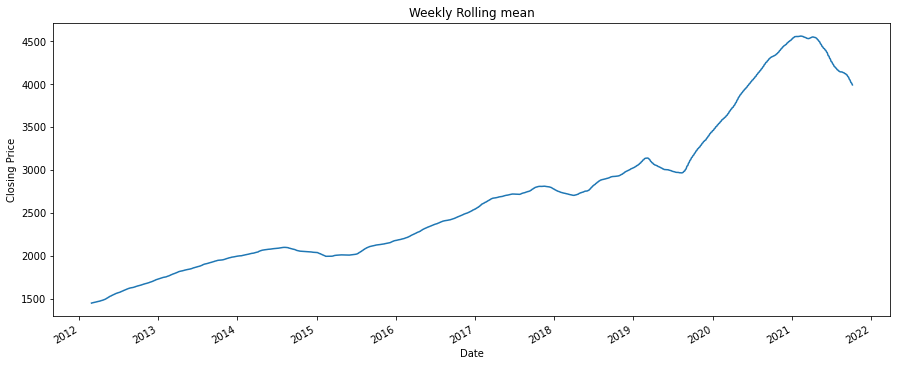

In [ ]:
# Weekly (5 days)
fig, ax = plt.subplots(figsize = (15,6))
data['Adj Close'].rolling(120).mean().plot(ax=ax, 
                                           xlabel = 'Date',
                                           ylabel = 'Closing Price',
                                           title = 'Weekly Rolling mean');

It can be seen that the Adj. price had some shocks in early 2020, resulting in the slump of the Adjusted close price. There was a recovery shortly after. We can zoom in, and see closely. 

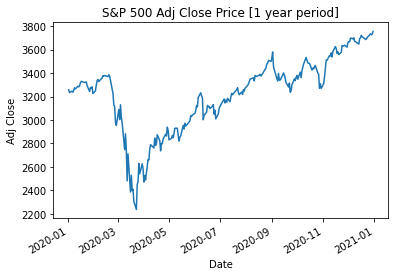

In [ ]:
# Subsetting the data for 2020
data_2020 = data['2020-01-01':'2020-12-31']
#data_2020 = data['2020']

# Plot the Adj Close of the GSPC
data_2020['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title('S&P 500 Adj Close Price [1 year period]')
plt.show()

In [ ]:
# Packages
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

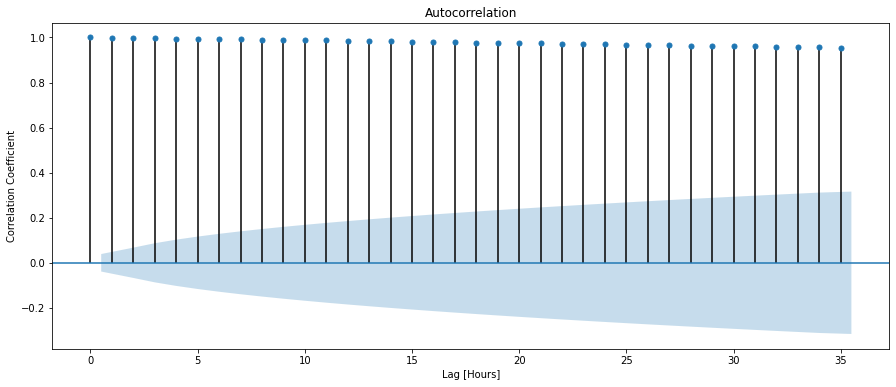

In [ ]:
# ACF plot
fig, ax = plt.subplots(figsize = (15,6))
plot_acf(data['Adj Close'], ax=ax)
plt.xlabel('Lag [Hours]')
plt.ylabel('Correlation Coefficient');

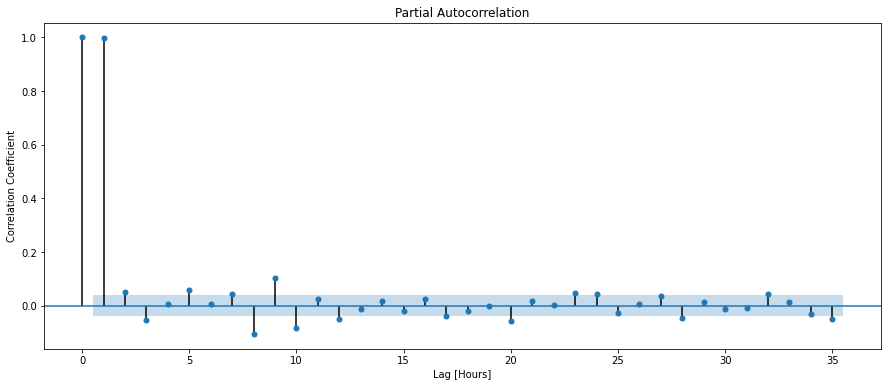

In [ ]:
#PACF
fig, ax = plt.subplots(figsize = (15,6))
plot_pacf(data['Adj Close'], ax=ax)
plt.xlabel('Lag [Hours]')
plt.ylabel('Correlation Coefficient');

Given what we have seen from the Partial Autocorrelation plot and the Autocorrelation plot we can see that there in an 'echo' in the data that riples till lag 35. Perhaps let us try to use 35 lags?

In [ ]:
data.index = pd.DatetimeIndex(data.index).to_period('D') # Setting the data period to a day

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [ ]:
# Train set 95%
y = data['Adj Close'].fillna(method='ffill')
cut_off = int(len(y)*0.95)
y_train = y.iloc[:cut_off]
y_test = y.iloc[cut_off:]

In [ ]:
# Base Model
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean S&P", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean S&P 2603.87
Baseline MAE: 676.49


In [ ]:
# Model
model = AutoReg(y_train, lags = 34).fit()
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[34:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 17.994967512812387


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


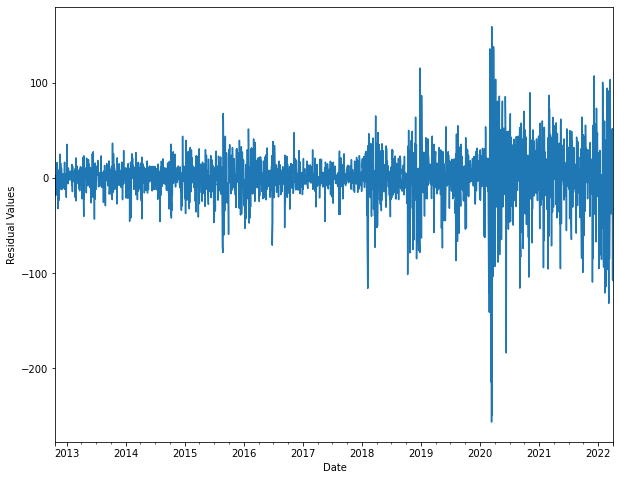

In [ ]:
# Checking residuals
y_train_resid = model.resid

fig, ax = plt.subplots(figsize = (10,8))
y_train_resid.plot(ylabel = 'Residual Values', ax=ax);

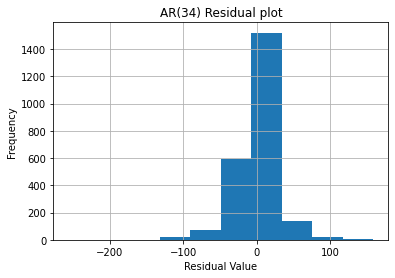

In [ ]:
y_train_resid.hist()
plt.ylabel('Frequency')
plt.xlabel('Residual Value')
plt.title('AR(34) Residual plot');

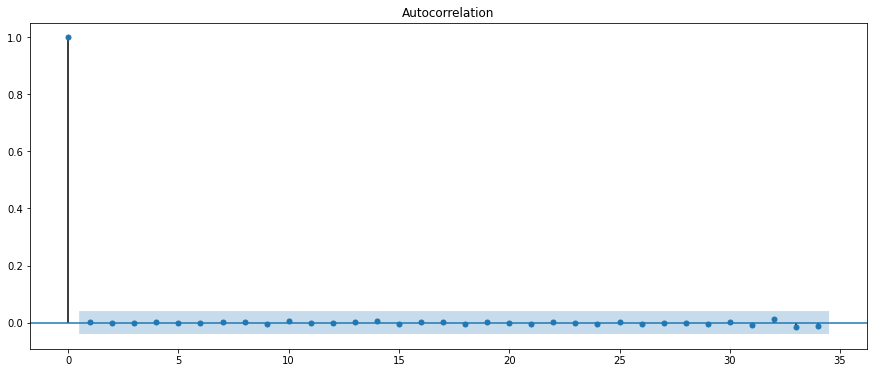

In [ ]:
# ACF of the residuals
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

# Evaluate

In [ ]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
#y_test = y_test.dropna()
#test_mae = mean_absolute_error(y_test, y_pred_test)
#print("Test MAE:", test_mae)
y_pred_test

2022-04-06    6906.024638
2022-04-07    6908.616469
2022-04-08    6911.209088
2022-04-09    6913.802496
2022-04-10    6916.396693
                 ...     
2022-10-03    7385.488987
2022-10-04    7388.226679
2022-10-05    7390.965205
2022-10-06    7393.704563
2022-10-07    7396.444754
Freq: D, Length: 185, dtype: float64

In [ ]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

In [ ]:
df_pred_test

,y_test,y_pred
Date,,
2022-04-06,4481.149902,6906.024638
2022-04-07,4500.209961,6908.616469
2022-04-08,4488.279785,6911.209088
2022-04-11,4412.529785,6918.991679
2022-04-12,4397.450195,6921.587454
...,...,...
2022-10-03,3678.429932,7385.488987
2022-10-04,3790.929932,7388.226679
2022-10-05,3783.280029,7390.965205


# ARIMA Models

Looks like the model is not doing well. Let us try to use Hyper-parameter tuning of the ARIMA models

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import time
import seaborn as sns

In [ ]:
# Parameters
d_params = range(0, 3, 1)
p_params =  range(0,36, 7)
q_params = range(0, 10, 1)

In [ ]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order = order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.57 seconds.
Trained ARIMA (0, 0, 1) in 0.54 seconds.
Trained ARIMA (0, 0, 2) in 1.84 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (0, 0, 3) in 4.67 seconds.
Trained ARIMA (0, 0, 4) in 5.6 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (0, 0, 5) in 14.78 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (0, 0, 6) in 18.87 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (0, 0, 7) in 12.52 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (0, 0, 8) in 14.55 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (0, 0, 9) in 20.75 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 0) in 8.8 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Trained ARIMA (7, 0, 1) in 7.87 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 2) in 8.83 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (7, 0, 3) in 10.21 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 4) in 13.04 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 5) in 11.38 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 6) in 11.37 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 7) in 11.28 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 8) in 15.49 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 9) in 17.6 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 0) in 21.19 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 1) in 21.75 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 2) in 21.37 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 3) in 24.16 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 4) in 27.88 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 5) in 26.15 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 6) in 28.23 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 7) in 29.48 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 8) in 31.53 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 9) in 31.28 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 0) in 50.83 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 1) in 55.92 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 2) in 50.75 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 3) in 54.24 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 4) in 60.39 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 5) in 59.46 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 6) in 59.79 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 7) in 61.36 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 8) in 73.35 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 9) in 66.29 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 0) in 105.45 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 1) in 101.65 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 2) in 110.62 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 3) in 101.42 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 4) in 105.19 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 5) in 101.35 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 6) in 107.36 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 7) in 114.13 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 8) in 116.75 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 9) in 116.31 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 0) in 208.0 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 1) in 227.36 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 2) in 222.37 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 3) in 220.97 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 4) in 226.15 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 5) in 231.33 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 6) in 223.86 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 7) in 229.77 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 8) in 238.39 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 9) in 243.61 seconds.

{0: [676.4914125505759, 352.17757024703576, 202.8406436651506, 125.4615031062849, 131.5767419107215, 112.36836452246779, 142.91895460390592, 190.52065620700984, 119.41232123685595, 116.5864352425338], 7: [20.968609411368394, 18.53414526533726, 18.450956267927175, 18.433947866895704, 18.44682649644495, 18.443034381219434, 18.421017228799382, 18.442969964209812, 18.433822246240553, 18.437973745694205], 14: [19.646500605194017, 18.4782902677019, 18.434100538306346, 18.43469850655604, 18.428012065003774, 18.438801318446554, 18.434751002013197, 18.446549303149595, 18.474766729749152, 18.447344673530374], 21: [19.260823950904516, 18.450195097714666, 18.44172009210287, 18.40952203665177, 18.382496021203167, 18.395687723133488, 18.439936521777454, 18.442159863200605, 18.41767089525517, 18.405904928937844], 28: [19.183501939615077, 18.456238027880616, 18.453104703632647, 18.432325933209583, 18.447871282269954, 18.413358838185268, 18.409495642677655, 

In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,7,14,21,28,35
0,676.4914,20.9686,19.6465,19.2608,19.1835,19.0917
1,352.1776,18.5341,18.4783,18.4502,18.4562,18.4802
2,202.8406,18.4510,18.4341,18.4417,18.4531,18.4383
3,125.4615,18.4339,18.4347,18.4095,18.4323,18.4468
4,131.5767,18.4468,18.4280,18.3825,18.4479,18.4243
5,112.3684,18.4430,18.4388,18.3957,18.4134,18.4110
6,142.9190,18.4210,18.4348,18.4399,18.4095,18.4055
7,190.5207,18.4430,18.4465,18.4422,18.4627,18.4367
8,119.4123,18.4338,18.4748,18.4177,18.4211,18.4419
9,116.5864,18.4380,18.4473,18.4059,18.4122,18.4053


In [ ]:
# Parameters
d_params = range(0, 3, 1)
p_params =  range(0,36, 7)
q_params = range(0, 4, 1)

In [26]:
# Differencing the data
# Create dictionary to store MAEs
mae_grid = dict()
for d in d_params:
    mae_grid[d] = list()
    for p in p_params:
        for q in q_params:
            # Combo of hyperparameters for model
            order = (p,d,q)
            # Note the start time
            start_time= time.time()
            # Train model
            model = ARIMA(y_train, order=order).fit()
            
            # Calculate model training time
            elapsed_time = round(time.time()- start_time,2)
            print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
            # Generate in-sample (training) predictions
            y_pred = model.predict()
            # Calculate training MAE
            mae = mean_absolute_error(y_train, y_pred)
            # Append MAE to list in dictionary
            mae_grid[d].append(mae)

print()
print(mae_grid)
            
    

Trained ARIMA (0, 0, 0) in 0.49 seconds.
Trained ARIMA (0, 0, 1) in 0.57 seconds.
Trained ARIMA (0, 0, 2) in 1.84 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Trained ARIMA (0, 0, 3) in 4.71 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 0) in 8.68 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Trained ARIMA (7, 0, 1) in 7.74 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 0, 2) in 8.78 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (7, 0, 3) in 10.17 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 0) in 21.08 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 1) in 23.27 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 2) in 21.52 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 0, 3) in 24.1 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 0) in 50.93 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 1) in 55.77 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 2) in 51.98 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 0, 3) in 52.9 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 0) in 103.77 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 1) in 103.41 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 2) in 108.89 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 0, 3) in 102.47 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 0) in 207.89 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 1) in 219.97 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 2) in 219.47 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 0, 3) in 220.97 seconds.
Trained ARIMA (0, 1, 0) in 0.08 seconds.
Trained ARIMA (0, 1, 1) in 0.23 seconds.
Trained ARIMA (0, 1, 2) in 0.31 seconds.
Trained ARIMA (0, 1, 3) in 0.5 seconds.
Trained ARIMA (7, 1, 0) in 0.4 seconds.
Trained ARIMA (7, 1, 1) in 1.59 seconds.
Trained ARIMA (7, 1, 2) in 3.71 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 1, 3) in 4.68 seconds.
Trained ARIMA (14, 1, 0) in 2.63 seconds.
Trained ARIMA (14, 1, 1) in 8.7 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 1, 2) in 11.66 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 1, 3) in 12.13 seconds.
Trained ARIMA (21, 1, 0) in 6.0 seconds.
Trained ARIMA (21, 1, 1) in 12.98 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 1, 2) in 23.2 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 1, 3) in 26.79 seconds.
Trained ARIMA (28, 1, 0) in 12.05 seconds.
Trained ARIMA (28, 1, 1) in 15.97 seconds.
Trained ARIMA (28, 1, 2) in 23.1 seconds.
Trained ARIMA (28, 1, 3) in 16.39 seconds.
Trained ARIMA (35, 1, 0) in 18.1 seconds.
Trained ARIMA (35, 1, 1) in 21.91 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 1, 2) in 65.33 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 1, 3) in 77.54 seconds.
Trained ARIMA (0, 2, 0) in 0.07 seconds.
Trained ARIMA (0, 2, 1) in 0.42 seconds.
Trained ARIMA (0, 2, 2) in 1.38 seconds.
Trained ARIMA (0, 2, 3) in 2.15 seconds.
Trained ARIMA (7, 2, 0) in 0.45 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 2, 1) in 6.59 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 2, 2) in 7.5 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (7, 2, 3) in 8.52 seconds.
Trained ARIMA (14, 2, 0) in 2.85 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 2, 1) in 15.3 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 2, 2) in 17.96 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (14, 2, 3) in 21.17 seconds.
Trained ARIMA (21, 2, 0) in 7.68 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 2, 1) in 34.53 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 2, 2) in 47.83 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (21, 2, 3) in 50.42 seconds.
Trained ARIMA (28, 2, 0) in 12.7 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 2, 1) in 77.8 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 2, 2) in 77.52 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (28, 2, 3) in 85.12 seconds.
Trained ARIMA (35, 2, 0) in 25.11 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 2, 1) in 126.97 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 2, 2) in 129.85 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (35, 2, 3) in 150.43 seconds.

{0: [676.4914125505759, 352.17757024703576, 202.8406436651506, 125.4615031062849, 20.968609411368394, 18.53414526533726, 18.450956267927175, 18.433947866895704, 19.646500605194017, 18.4782902677019, 18.434100538306346, 18.43469850655604, 19.260823950904516, 18.450195097714666, 18.44172009210287, 18.40952203665177, 19.183501939615077, 18.456238027880616, 18.453104703632647, 18.432325933209583, 19.091684029133972, 18.480188380438772, 18.438281224934403, 18.446751625535825], 1: [18.529930851442707, 18.5205992474567, 18.49430169388084, 18.499412524345946, 18.60322319886595, 18.57727280164123, 18.516434517702695, 18.520836403197226, 18.55095874589604, 18.53622999572483, 18.556088885352047, 18.557418012069924, 18.519881160093696, 18.517989260684093, 18.490127309150143, 18.48226159158415, 18.561183368364134, 18.561083706643817, 18.5589313499872, 18.556904409226195, 18.565006261919653, 18.564715503203345, 18.539841289749962, 18.524825412265017], 2: 

In [27]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2
0,676.4914,18.5299,27.1638
1,352.1776,18.5206,18.7795
2,202.8406,18.4943,18.7358
3,125.4615,18.4994,18.7272
4,20.9686,18.6032,19.9910
5,18.5341,18.5773,18.8255
6,18.4510,18.5164,18.8042
7,18.4339,18.5208,18.7335
8,19.6465,18.5510,19.4430
9,18.4783,18.5362,18.7793


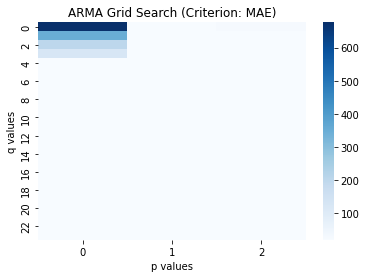

In [28]:
sns.heatmap(mae_df, cmap = 'Blues')
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('ARMA Grid Search (Criterion: MAE)');

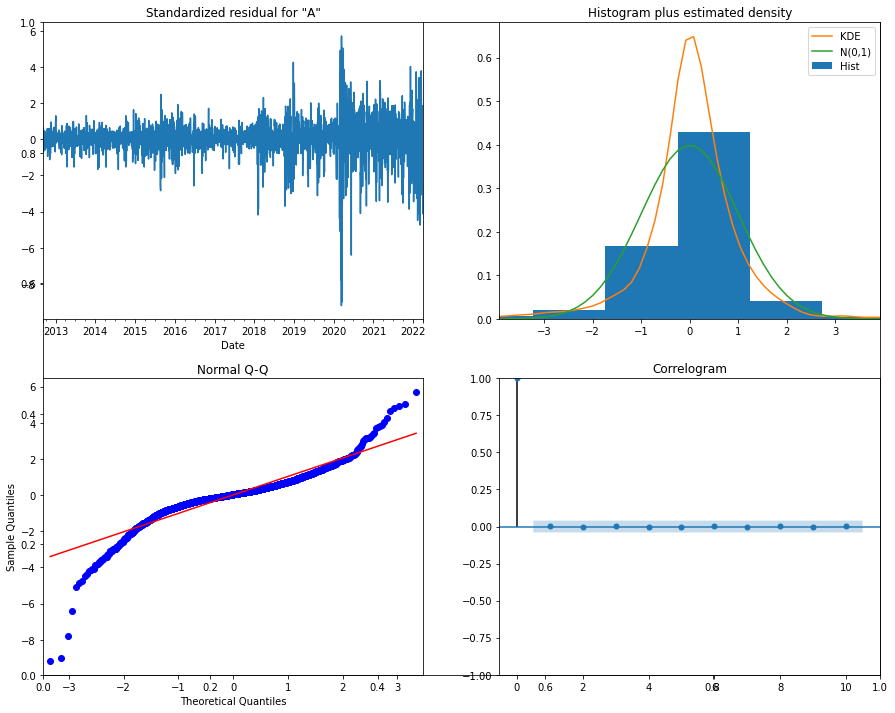

In [29]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

In [30]:
#Model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2413
Model:                ARIMA(35, 2, 3)   Log Likelihood              -11464.771
Date:                Tue, 18 Oct 2022   AIC                          23007.541
Time:                        11:41:53   BIC                          23233.266
Sample:                    09-04-2012   HQIC                         23089.641
                         - 04-05-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7318      0.078    -22.342      0.000      -1.884      -1.580
ar.L2         -0.9085      0.086    -10.613      0.000      -1.076      -0.741
ar.L3          0.0141      0.025      0.560      0.575      -0.035       0.063
ar.L4         -0.0149      0.026     -0.575      0.565      -0.066       0.036
ar.L5         -0.0839      0.025     -3.369      0.001      -0.133      -0.035
ar.L6         -0.0918      0.027     -3.442      0.001      -0.144      -0.040
ar.L7          0.0084      0.026      0.326      0.744      -0.042       0.059
ar.L8          0.0227      0.026      0.879      0.379      -0.028       0.073
ar.L9          0.0180      0.025      0.729      0.466      -0.030       0.066
ar.L10         0.0324      0.026      1.264      0.206      -0.018       0.083
ar.L11         0.0264      0.028      0.945      0.345      -0.028       0.081
ar.L12         0.0206      0.028      0.734      0.463      -0.034       0.076
ar.L13         0.0115      0.028      0.415      0.678      -0.043       0.066
ar.L14        -0.0440      0.028     -1.577      0.115      -0.099       0.011
ar.L15        -0.0456      0.030     -1.520      0.128      -0.104       0.013
ar.L16        -0.0192      0.030     -0.634      0.526      -0.079       0.040
ar.L17        -0.0154      0.030     -0.505      0.613      -0.075       0.044
ar.L18        -0.0477      0.030     -1.565      0.117      -0.107       0.012
ar.L19        -0.0645      0.030     -2.160      0.031      -0.123      -0.006
ar.L20        -0.0455      0.031     -1.460      0.144      -0.107       0.016
ar.L21        -0.0150      0.031     -0.480      0.631      -0.076       0.046
ar.L22        -0.0318      0.031     -1.025      0.305      -0.093       0.029
ar.L23        -0.1002      0.033     -2.993      0.003      -0.166      -0.035
ar.L24        -0.1068      0.036     -2.986      0.003      -0.177      -0.037
ar.L25        -0.0468      0.033     -1.404      0.160      -0.112       0.019
ar.L26        -0.0581      0.032     -1.789      0.074      -0.122       0.006
ar.L27        -0.0290      0.033     -0.866      0.386      -0.095       0.037
ar.L28         0.0071      0.032      0.220      0.826      -0.056       0.071
ar.L29        -0.0285      0.032     -0.882      0.378      -0.092       0.035
ar.L30        -0.0447      0.033     -1.367      0.172      -0.109       0.019
ar.L31        -0.0177      0.033     -0.544      0.586      -0.082       0.046
ar.L32        -0.0148      0.035     -0.417      0.677      -0.084       0.055
ar.L33        -0.0030      0.036     -0.082      0.935      -0.074       0.068
ar.L34        -0.0087      0.033     -0.261      0.794      -0.074       0.056
ar.L35        -0.0179      0.018     -1.005      0.315      -0.053       0.017
ma.L1          0.6532      0.076      8.644      0.000       0.505       0.801
ma.L2         -0.8323      0.035    -23.980      0.000      -0.900      -0.764
ma.L3         -0.8201      0.075    -10.996      0.000      -0.966      -0.674
si

In [31]:
#Tuned model
y_pred = model.predict()
training_mae = mean_absolute_error(y_train, y_pred)
print("Training MAE:", training_mae)

Training MAE: 18.76154470318319


The Hyper Tuned model is outperformed by the untuned model 

# Final model

In [32]:
# Model
model = AutoReg(y_train, lags = 34).fit()
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[34:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 17.994967512812387


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
